<a href="https://colab.research.google.com/github/Evanaxander/Bangladesh-flood-prediction/blob/main/Bangladesh_flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Required Libraries**

In [4]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Warnings
import warnings
warnings.filterwarnings("ignore")


**Load Data & Create Flood Label**

In [5]:
# 2. Load dataset
df = pd.read_csv("flood_data.csv")

# Drop redundant index column if present
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Create Flood label
df['Flood'] = df['Rainfall'].apply(lambda x: 1 if x > 400 else 0)

# Check balance
print(df['Flood'].value_counts(normalize=True))  # class balance

df.head()


Flood
0    0.830492
1    0.169508
Name: proportion, dtype: float64


,Station Names,YEAR,Month,Max Temp,Min Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Station Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood
0,Barisal,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,0
1,Barisal,1950,1,30.0,14.1,0.0,77.0,0.453704,0.8,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1950.01,0
2,Barisal,1951,1,28.2,12.3,0.0,77.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1951.01,0
3,Barisal,1952,1,26.6,12.3,2.0,77.0,0.453704,1.0,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1952.01,0
4,Barisal,1953,1,30.0,13.3,10.0,75.0,0.453704,1.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1953.01,0


**Preprocessing**

In [6]:
# 3. Encode categorical column: Station Names
le = LabelEncoder()
df['Station'] = le.fit_transform(df['Station Names'])

# Drop original Station Names and location metadata (lat/lon if you prefer)
df.drop(['Station Names', 'X_COR', 'Y_COR', 'LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

# Features and labels
X = df.drop(['Flood'], axis=1)
y = df['Flood']

# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Exploratory Data Analysis (EDA)**

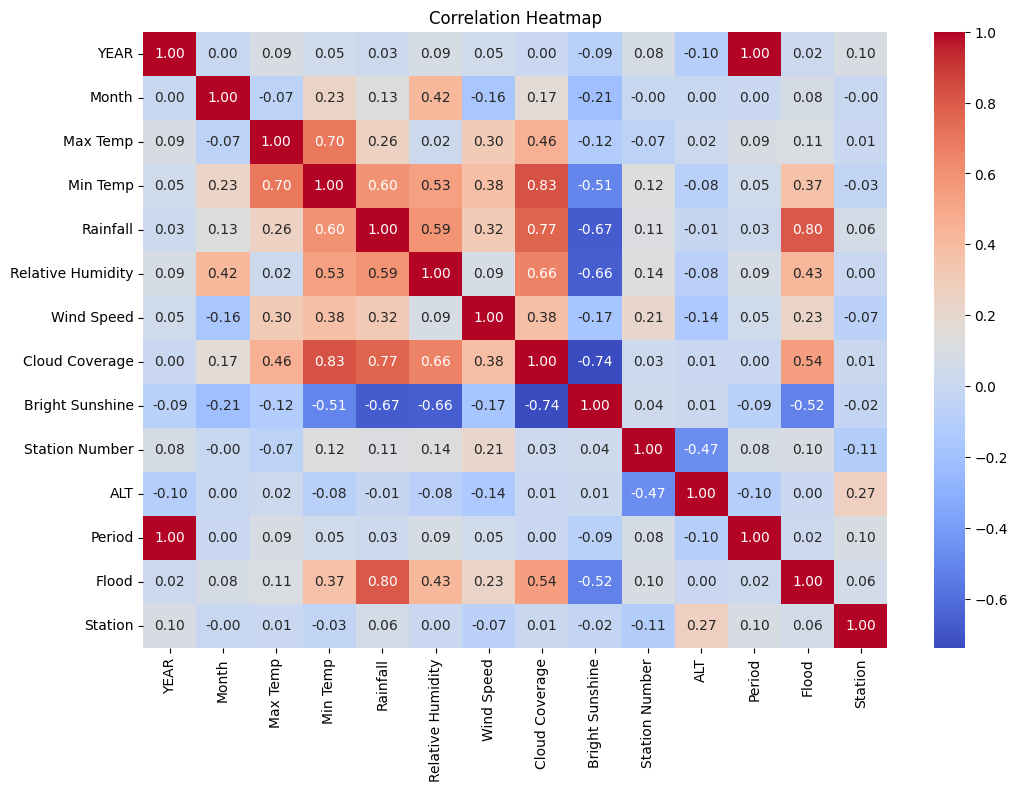

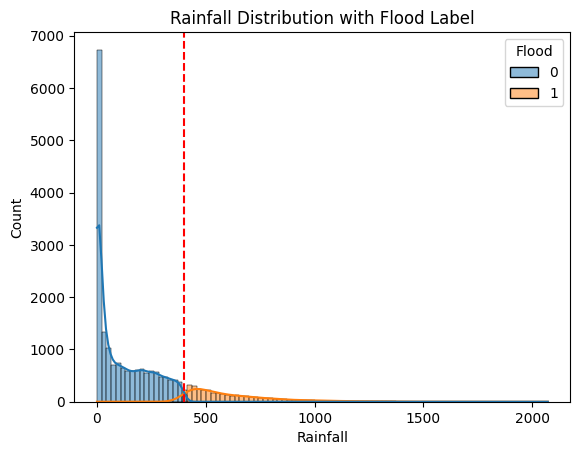

In [7]:
# 4.1 Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 4.2 Rainfall vs Flood distribution
sns.histplot(data=df, x='Rainfall', hue='Flood', kde=True)
plt.axvline(x=400, color='red', linestyle='--')
plt.title("Rainfall Distribution with Flood Label")
plt.show()


**Model Training & Evaluation**

In [8]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print(f"--- {name} ---")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    if proba is not None:
        auc = roc_auc_score(y_test, proba)
        print(f"ROC AUC Score: {auc:.4f}")
    print("\n")


Logistic Regression

In [9]:
lr = LogisticRegression()
evaluate_model("Logistic Regression", lr, X_train_scaled, X_test_scaled, y_train, y_test)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3508
           1       1.00      0.99      0.99       716

    accuracy                           1.00      4224
   macro avg       1.00      1.00      1.00      4224
weighted avg       1.00      1.00      1.00      4224

Confusion Matrix:
 [[3505    3]
 [   6  710]]
ROC AUC Score: 1.0000




Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test)


--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3508
           1       1.00      1.00      1.00       716

    accuracy                           1.00      4224
   macro avg       1.00      1.00      1.00      4224
weighted avg       1.00      1.00      1.00      4224

Confusion Matrix:
 [[3508    0]
 [   0  716]]
ROC AUC Score: 1.0000




 XGBoost

In [11]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)


--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3508
           1       1.00      1.00      1.00       716

    accuracy                           1.00      4224
   macro avg       1.00      1.00      1.00      4224
weighted avg       1.00      1.00      1.00      4224

Confusion Matrix:
 [[3506    2]
 [   3  713]]
ROC AUC Score: 1.0000




Support Vector Machine (SVM)

In [12]:
svm_model = SVC(kernel='rbf', probability=True)
evaluate_model("SVM", svm_model, X_train_scaled, X_test_scaled, y_train, y_test)


--- SVM ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3508
           1       0.99      0.97      0.98       716

    accuracy                           0.99      4224
   macro avg       0.99      0.98      0.99      4224
weighted avg       0.99      0.99      0.99      4224

Confusion Matrix:
 [[3501    7]
 [  24  692]]
ROC AUC Score: 0.9998




Neural Network (MLP)

In [13]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
evaluate_model("MLP Neural Network", mlp, X_train_scaled, X_test_scaled, y_train, y_test)


--- MLP Neural Network ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3508
           1       0.99      0.99      0.99       716

    accuracy                           1.00      4224
   macro avg       1.00      1.00      1.00      4224
weighted avg       1.00      1.00      1.00      4224

Confusion Matrix:
 [[3503    5]
 [   4  712]]
ROC AUC Score: 1.0000




**Model Comparison Summary**

In [14]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "XGBoost": xgb_model,
    "SVM": svm_model,
    "MLP": mlp
}

print("=== 10-Fold Cross-Validation Accuracy Scores ===")
for name, model in models.items():
    X_used = X_train_scaled if name in ["Logistic Regression", "SVM", "MLP"] else X_train
    scores = cross_val_score(model, X_used, y_train, cv=10, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


=== 10-Fold Cross-Validation Accuracy Scores ===
Logistic Regression: 0.9979 (+/- 0.0008)
Random Forest: 1.0000 (+/- 0.0000)
XGBoost: 0.9986 (+/- 0.0008)
SVM: 0.9929 (+/- 0.0016)
MLP: 0.9960 (+/- 0.0009)


**Save Best Model**

In [15]:
import joblib

# Save the best model (replace xgb_model with your best performing)
joblib.dump(xgb_model, 'flood_predictor_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']